In [2]:
import nltk
from nltk.corpus import brown
import random 
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

def importdata():
	nltk.download('brown')
	nltk.download('universal_tagset')


def getRows():

	Sentences = nltk.corpus.brown.sents(categories=nltk.corpus.brown.categories())
	return Sentences


def getTaggedWords():

	return nltk.corpus.brown.tagged_words(tagset='universal')


def getTaggedSent():
	return nltk.corpus.brown.tagged_sents(categories= nltk.corpus.brown.categories(), tagset='universal')


def Parition_in_n(input_list, n):
    random.shuffle(input_list)
    return [input_list[i::n] for i in range(n)]


In [3]:
importdata()

List_of_Tags = []
List_of_Words = []

indextags = {}
indexwords = {}

Tagged_words = getTaggedWords()

Tagged_Sentences = getTaggedSent()

for words in Tagged_words:
  List_of_Tags.append(words[1])
  List_of_Words.append(words[0].lower())

List_of_Words.append('st')
List_of_Words.append('endt')

List_of_Tags.append('st')
List_of_Tags.append('endt')

Set_of_Words = list(set(List_of_Words))
Set_of_Tags = list(set(List_of_Tags))

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


In [4]:
###########Smoothening Parameters###########
Lambda = 0.01
V = len(Set_of_Words)
#############################################

Dataset_Partition = Parition_in_n(list(Tagged_Sentences),5)

#########Assigning Index to Words and Tagset for Probability Matrix######
for x in range(0,len(Set_of_Tags)):
  indextags[Set_of_Tags[x]] = x

for x in range(0,len(Set_of_Words)):
  indexwords[Set_of_Words[x]] = x


In [5]:
import torch
import torch.nn as nn
class BiLSTMNet(nn.Module):
  def __init__(self, hidden_dim, num_words, n_layers=1, seqLength=20, numTags=14):
    super(BiLSTMNet, self).__init__()
    self.hidden_dim = hidden_dim
    self.embeddings = nn.Embedding(num_words, hidden_dim)
    self.bilstm = nn.LSTM(hidden_dim, hidden_dim, n_layers, batch_first=True, bidirectional = True)
    self.fc = nn.Linear(hidden_dim*2,numTags)
    self.dropout = nn.Dropout(0.3)
    self.softmax = nn.Softmax(dim=2)

  def forward(self,x):
    x = self.embeddings(x)
    unpacked, (h_n, c_n) = self.bilstm(x)
    out = self.fc(unpacked)
    out = self.dropout(out)
    return self.softmax(out)

In [6]:
class Data:
  def __init__(self, indexwords, indextags, batch_size, seq_length):
    self.indexwords = indexwords.copy()
    self.indextags = indextags
    self.batch_size = batch_size
    self.seq_length = seq_length
      
  def one_hot_word(self, word):

    return self.indexwords[word]

  def one_hot_tag(self, tag):
    x = np.zeros(len(self.indextags))
    x[self.indextags[tag]] = 1.
    return np.asarray(x)

  def preprocess(self, dataset_list):
    word_dataset = []
    tag_dataset = []
    word_dataset_batch = []
    tag_dataset_batch = []
    seq_len = []
    for i in range(len(dataset_list)):
      wd = []
      td = []
      for j in dataset_list[i]:
        word = self.one_hot_word(j[0].lower())
        tag = self.one_hot_tag(j[1])
        wd.append(word)
        td.append(tag)
      seq_len.append(len(wd))

      word_dataset.append(np.array(wd))
      tag_dataset.append(np.array(td))
    
    return word_dataset, tag_dataset



In [7]:
gpu = 0
device = torch.device(gpu if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    torch.cuda.set_device(gpu)
print(device)

cuda:0


In [8]:
from tqdm import tqdm

In [9]:
for test_index in range(0,5):
  Train_set = []
  Test_set = []
  for training_index in range(0,5):

    if training_index == test_index:
      Test_set.extend(Dataset_Partition[training_index])
      continue
    Train_set.extend(Dataset_Partition[training_index])

  train_data = Data(indexwords, indextags, 32, 20)
  word_set, tag_set = train_data.preprocess(Train_set)

  test_data = Data(indexwords, indextags, 32, 20)
  test_word_set, test_tag_set = test_data.preprocess(Test_set)

  ###Model Parameters
  loss_criteria = nn.BCELoss()
  model = BiLSTMNet(256, len(indexwords))
  model = model.to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
  epochs = 5
  ###Training
  a = len(word_set)
  model.train()
  loss_total = 0
  
  for _ in tqdm(range(epochs)):
    print("*"*100)
    for i in range(a):
      out = model(torch.tensor(word_set[i]).unsqueeze(0).to(device))
      loss = loss_criteria(out[0], torch.tensor(tag_set[i]).float().to(device))
      loss.backward()
      loss_total+= loss.detach().cpu()
      if i%4096==0 and i!=0:
        print(f"loss: {loss_total} for batch size:4096 cross validation: {test_index+1}" )
        
        optimizer.step()
        optimizer.zero_grad()
        loss_total = 0

  ###Testing
  b = len(test_word_set)
  model.eval()
  pred_all = []
  gold_all = []
  for i in range(b):
    out = model(torch.tensor(test_word_set[i]).unsqueeze(0).to(device))
    
    pred = torch.argmax(out[0], dim=1)
    gold = np.argmax(test_tag_set[i], axis=1)
   
    pred_all.extend(pred.detach().cpu().data)
    gold_all.extend(gold)
  torch.save(model.state_dict(), f'POS_bilstm_{test_index+1}.pt')
  print('-'*100)
  print(f"Performance of Cross validation: {test_index+1} ")
  print(f"Accuracy: {accuracy_score(gold_all, pred_all)}")
  print(classification_report(gold_all, pred_all))
  print('-'*100)

  0%|          | 0/5 [00:00<?, ?it/s]

****************************************************************************************************
loss: 1057.865478515625 for batch size:4096 cross validation: 1
loss: 816.4102783203125 for batch size:4096 cross validation: 1
loss: 934.930419921875 for batch size:4096 cross validation: 1
loss: 675.7109375 for batch size:4096 cross validation: 1
loss: 661.2625122070312 for batch size:4096 cross validation: 1
loss: 624.7356567382812 for batch size:4096 cross validation: 1
loss: 586.6181640625 for batch size:4096 cross validation: 1
loss: 541.8458251953125 for batch size:4096 cross validation: 1
loss: 508.6564025878906 for batch size:4096 cross validation: 1
loss: 481.636474609375 for batch size:4096 cross validation: 1
loss: 473.40765380859375 for batch size:4096 cross validation: 1


 20%|██        | 1/5 [03:57<15:48, 237.12s/it]

****************************************************************************************************
loss: 538.4664306640625 for batch size:4096 cross validation: 1
loss: 424.66009521484375 for batch size:4096 cross validation: 1
loss: 411.85540771484375 for batch size:4096 cross validation: 1
loss: 399.8013610839844 for batch size:4096 cross validation: 1
loss: 384.032958984375 for batch size:4096 cross validation: 1
loss: 375.2386169433594 for batch size:4096 cross validation: 1
loss: 365.5683288574219 for batch size:4096 cross validation: 1
loss: 355.1776123046875 for batch size:4096 cross validation: 1
loss: 342.3537292480469 for batch size:4096 cross validation: 1
loss: 336.00274658203125 for batch size:4096 cross validation: 1
loss: 329.6739196777344 for batch size:4096 cross validation: 1


 40%|████      | 2/5 [07:53<11:50, 236.93s/it]

****************************************************************************************************
loss: 384.10809326171875 for batch size:4096 cross validation: 1
loss: 310.6672668457031 for batch size:4096 cross validation: 1
loss: 309.2188720703125 for batch size:4096 cross validation: 1
loss: 304.6513977050781 for batch size:4096 cross validation: 1
loss: 291.0354309082031 for batch size:4096 cross validation: 1
loss: 291.3410949707031 for batch size:4096 cross validation: 1
loss: 285.9700012207031 for batch size:4096 cross validation: 1
loss: 285.0627746582031 for batch size:4096 cross validation: 1
loss: 275.48095703125 for batch size:4096 cross validation: 1
loss: 274.0218505859375 for batch size:4096 cross validation: 1
loss: 273.2123718261719 for batch size:4096 cross validation: 1


 60%|██████    | 3/5 [11:49<07:53, 236.69s/it]

****************************************************************************************************
loss: 323.2516174316406 for batch size:4096 cross validation: 1
loss: 261.6473693847656 for batch size:4096 cross validation: 1
loss: 265.7864990234375 for batch size:4096 cross validation: 1
loss: 257.4601745605469 for batch size:4096 cross validation: 1
loss: 259.13916015625 for batch size:4096 cross validation: 1
loss: 253.513671875 for batch size:4096 cross validation: 1
loss: 253.37863159179688 for batch size:4096 cross validation: 1
loss: 251.17877197265625 for batch size:4096 cross validation: 1
loss: 250.466796875 for batch size:4096 cross validation: 1
loss: 249.17803955078125 for batch size:4096 cross validation: 1
loss: 246.87530517578125 for batch size:4096 cross validation: 1


 80%|████████  | 4/5 [15:46<03:56, 236.60s/it]

****************************************************************************************************
loss: 298.8458557128906 for batch size:4096 cross validation: 1
loss: 246.5955047607422 for batch size:4096 cross validation: 1
loss: 244.943115234375 for batch size:4096 cross validation: 1
loss: 241.4124755859375 for batch size:4096 cross validation: 1
loss: 242.86898803710938 for batch size:4096 cross validation: 1
loss: 240.99734497070312 for batch size:4096 cross validation: 1
loss: 239.4894256591797 for batch size:4096 cross validation: 1
loss: 239.1848602294922 for batch size:4096 cross validation: 1
loss: 238.87388610839844 for batch size:4096 cross validation: 1
loss: 237.39620971679688 for batch size:4096 cross validation: 1
loss: 237.4597930908203 for batch size:4096 cross validation: 1


100%|██████████| 5/5 [19:40<00:00, 236.11s/it]


----------------------------------------------------------------------------------------------------
Performance of Cross validation: 1 
Accuracy: 0.9698258220998712
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     27415
           1       0.96      0.97      0.97     36291
           2       0.96      0.97      0.96     54986
           3       0.98      0.98      0.98     29151
           4       0.95      0.88      0.91      3014
           7       1.00      1.00      1.00     29357
           8       0.94      0.95      0.94      5992
           9       0.87      0.10      0.17       282
          10       0.93      0.93      0.93     11224
          11       0.99      0.98      0.99      9875
          12       0.93      0.91      0.92     16877
          13       0.99      1.00      0.99      7655

    accuracy                           0.97    232119
   macro avg       0.96      0.89      0.90    232119
weighted avg       0.9

  0%|          | 0/5 [00:00<?, ?it/s]

****************************************************************************************************
loss: 1057.5330810546875 for batch size:4096 cross validation: 2
loss: 819.3674926757812 for batch size:4096 cross validation: 2
loss: 801.76611328125 for batch size:4096 cross validation: 2
loss: 661.3092651367188 for batch size:4096 cross validation: 2
loss: 638.1906127929688 for batch size:4096 cross validation: 2
loss: 599.014404296875 for batch size:4096 cross validation: 2
loss: 553.96923828125 for batch size:4096 cross validation: 2
loss: 512.4955444335938 for batch size:4096 cross validation: 2
loss: 484.09722900390625 for batch size:4096 cross validation: 2
loss: 469.9002685546875 for batch size:4096 cross validation: 2
loss: 455.80072021484375 for batch size:4096 cross validation: 2


 20%|██        | 1/5 [03:55<15:40, 235.15s/it]

****************************************************************************************************
loss: 512.5543212890625 for batch size:4096 cross validation: 2
loss: 406.748291015625 for batch size:4096 cross validation: 2
loss: 396.7989807128906 for batch size:4096 cross validation: 2
loss: 383.1300048828125 for batch size:4096 cross validation: 2
loss: 375.7508544921875 for batch size:4096 cross validation: 2
loss: 363.08843994140625 for batch size:4096 cross validation: 2
loss: 355.1935729980469 for batch size:4096 cross validation: 2
loss: 343.4229431152344 for batch size:4096 cross validation: 2
loss: 336.4972839355469 for batch size:4096 cross validation: 2
loss: 325.0169677734375 for batch size:4096 cross validation: 2
loss: 320.9769592285156 for batch size:4096 cross validation: 2


 40%|████      | 2/5 [07:50<11:45, 235.27s/it]

****************************************************************************************************
loss: 376.71783447265625 for batch size:4096 cross validation: 2
loss: 304.9775390625 for batch size:4096 cross validation: 2
loss: 304.6899108886719 for batch size:4096 cross validation: 2
loss: 292.2120666503906 for batch size:4096 cross validation: 2
loss: 291.485595703125 for batch size:4096 cross validation: 2
loss: 285.14892578125 for batch size:4096 cross validation: 2
loss: 283.6674499511719 for batch size:4096 cross validation: 2
loss: 274.6639404296875 for batch size:4096 cross validation: 2
loss: 275.25189208984375 for batch size:4096 cross validation: 2
loss: 271.546142578125 for batch size:4096 cross validation: 2
loss: 267.9179992675781 for batch size:4096 cross validation: 2


 60%|██████    | 3/5 [11:46<07:50, 235.42s/it]

****************************************************************************************************
loss: 321.6766357421875 for batch size:4096 cross validation: 2
loss: 260.6460266113281 for batch size:4096 cross validation: 2
loss: 263.60107421875 for batch size:4096 cross validation: 2
loss: 255.35617065429688 for batch size:4096 cross validation: 2
loss: 254.24679565429688 for batch size:4096 cross validation: 2
loss: 255.1262969970703 for batch size:4096 cross validation: 2
loss: 254.63194274902344 for batch size:4096 cross validation: 2
loss: 252.11312866210938 for batch size:4096 cross validation: 2
loss: 248.05616760253906 for batch size:4096 cross validation: 2
loss: 248.97537231445312 for batch size:4096 cross validation: 2
loss: 246.9200897216797 for batch size:4096 cross validation: 2


 80%|████████  | 4/5 [15:40<03:54, 234.97s/it]

****************************************************************************************************
loss: 295.1912536621094 for batch size:4096 cross validation: 2
loss: 246.72305297851562 for batch size:4096 cross validation: 2
loss: 240.6804962158203 for batch size:4096 cross validation: 2
loss: 244.63168334960938 for batch size:4096 cross validation: 2
loss: 238.09632873535156 for batch size:4096 cross validation: 2
loss: 238.68295288085938 for batch size:4096 cross validation: 2
loss: 236.87939453125 for batch size:4096 cross validation: 2
loss: 236.05592346191406 for batch size:4096 cross validation: 2
loss: 238.1331024169922 for batch size:4096 cross validation: 2
loss: 234.48818969726562 for batch size:4096 cross validation: 2
loss: 236.972412109375 for batch size:4096 cross validation: 2


100%|██████████| 5/5 [19:34<00:00, 234.89s/it]


----------------------------------------------------------------------------------------------------
Performance of Cross validation: 2 
Accuracy: 0.9690730960450034
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     27398
           1       0.96      0.97      0.96     36723
           2       0.96      0.96      0.96     55093
           3       0.98      0.98      0.98     28901
           4       0.93      0.87      0.90      2989
           7       1.00      1.00      1.00     29686
           8       0.95      0.94      0.95      6040
           9       0.65      0.06      0.12       314
          10       0.93      0.93      0.93     11181
          11       0.99      0.99      0.99      9826
          12       0.92      0.91      0.92     16736
          13       0.99      1.00      1.00      7629

    accuracy                           0.97    232516
   macro avg       0.94      0.88      0.89    232516
weighted avg       0.9

  0%|          | 0/5 [00:00<?, ?it/s]

****************************************************************************************************
loss: 1060.49853515625 for batch size:4096 cross validation: 3
loss: 817.948486328125 for batch size:4096 cross validation: 3
loss: 864.66455078125 for batch size:4096 cross validation: 3
loss: 659.0076293945312 for batch size:4096 cross validation: 3
loss: 639.7431640625 for batch size:4096 cross validation: 3
loss: 602.813720703125 for batch size:4096 cross validation: 3
loss: 563.78857421875 for batch size:4096 cross validation: 3
loss: 519.8065795898438 for batch size:4096 cross validation: 3
loss: 487.2669372558594 for batch size:4096 cross validation: 3
loss: 469.07830810546875 for batch size:4096 cross validation: 3
loss: 457.84637451171875 for batch size:4096 cross validation: 3


 20%|██        | 1/5 [03:52<15:31, 232.97s/it]

****************************************************************************************************
loss: 515.9690551757812 for batch size:4096 cross validation: 3
loss: 410.500244140625 for batch size:4096 cross validation: 3
loss: 398.55535888671875 for batch size:4096 cross validation: 3
loss: 386.3537902832031 for batch size:4096 cross validation: 3
loss: 375.8664855957031 for batch size:4096 cross validation: 3
loss: 362.0844421386719 for batch size:4096 cross validation: 3
loss: 356.7456970214844 for batch size:4096 cross validation: 3
loss: 347.4501037597656 for batch size:4096 cross validation: 3
loss: 335.17041015625 for batch size:4096 cross validation: 3
loss: 326.5341491699219 for batch size:4096 cross validation: 3
loss: 322.60284423828125 for batch size:4096 cross validation: 3


 40%|████      | 2/5 [07:45<11:38, 232.94s/it]

****************************************************************************************************
loss: 379.24615478515625 for batch size:4096 cross validation: 3
loss: 308.2839050292969 for batch size:4096 cross validation: 3
loss: 304.4183044433594 for batch size:4096 cross validation: 3
loss: 297.77972412109375 for batch size:4096 cross validation: 3
loss: 294.33001708984375 for batch size:4096 cross validation: 3
loss: 287.5395812988281 for batch size:4096 cross validation: 3
loss: 281.65216064453125 for batch size:4096 cross validation: 3
loss: 281.30072021484375 for batch size:4096 cross validation: 3
loss: 275.8646545410156 for batch size:4096 cross validation: 3
loss: 268.7291564941406 for batch size:4096 cross validation: 3
loss: 269.06396484375 for batch size:4096 cross validation: 3


 60%|██████    | 3/5 [11:38<07:45, 232.79s/it]

****************************************************************************************************
loss: 321.7615661621094 for batch size:4096 cross validation: 3
loss: 264.4790344238281 for batch size:4096 cross validation: 3
loss: 263.3395080566406 for batch size:4096 cross validation: 3
loss: 254.34213256835938 for batch size:4096 cross validation: 3
loss: 257.26904296875 for batch size:4096 cross validation: 3
loss: 254.2268829345703 for batch size:4096 cross validation: 3
loss: 253.35116577148438 for batch size:4096 cross validation: 3
loss: 249.9674530029297 for batch size:4096 cross validation: 3
loss: 246.6578369140625 for batch size:4096 cross validation: 3
loss: 247.3333282470703 for batch size:4096 cross validation: 3
loss: 248.0232391357422 for batch size:4096 cross validation: 3


 80%|████████  | 4/5 [15:30<03:52, 232.62s/it]

****************************************************************************************************
loss: 297.0107727050781 for batch size:4096 cross validation: 3
loss: 242.8356475830078 for batch size:4096 cross validation: 3
loss: 244.7036895751953 for batch size:4096 cross validation: 3
loss: 240.44349670410156 for batch size:4096 cross validation: 3
loss: 240.918212890625 for batch size:4096 cross validation: 3
loss: 240.68014526367188 for batch size:4096 cross validation: 3
loss: 237.47181701660156 for batch size:4096 cross validation: 3
loss: 237.6737060546875 for batch size:4096 cross validation: 3
loss: 234.2213897705078 for batch size:4096 cross validation: 3
loss: 233.58572387695312 for batch size:4096 cross validation: 3
loss: 238.97911071777344 for batch size:4096 cross validation: 3


100%|██████████| 5/5 [19:22<00:00, 232.54s/it]


----------------------------------------------------------------------------------------------------
Performance of Cross validation: 3 
Accuracy: 0.9699120506094738
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     27578
           1       0.96      0.97      0.97     36625
           2       0.96      0.96      0.96     55627
           3       0.98      0.98      0.98     29032
           4       0.94      0.90      0.92      3016
           7       1.00      1.00      1.00     29633
           8       0.95      0.94      0.94      5807
           9       0.76      0.13      0.22       268
          10       0.94      0.94      0.94     11220
          11       0.99      0.99      0.99      9835
          12       0.92      0.91      0.92     16976
          13       0.99      1.00      0.99      7699

    accuracy                           0.97    233316
   macro avg       0.95      0.89      0.90    233316
weighted avg       0.9

  0%|          | 0/5 [00:00<?, ?it/s]

****************************************************************************************************
loss: 1056.369140625 for batch size:4096 cross validation: 4
loss: 814.0780029296875 for batch size:4096 cross validation: 4
loss: 835.1301879882812 for batch size:4096 cross validation: 4
loss: 667.00341796875 for batch size:4096 cross validation: 4
loss: 644.978759765625 for batch size:4096 cross validation: 4
loss: 604.0875244140625 for batch size:4096 cross validation: 4
loss: 561.8514404296875 for batch size:4096 cross validation: 4
loss: 520.0667114257812 for batch size:4096 cross validation: 4
loss: 483.980224609375 for batch size:4096 cross validation: 4
loss: 469.57598876953125 for batch size:4096 cross validation: 4
loss: 457.73309326171875 for batch size:4096 cross validation: 4


 20%|██        | 1/5 [03:53<15:33, 233.40s/it]

****************************************************************************************************
loss: 516.5307006835938 for batch size:4096 cross validation: 4
loss: 413.9569396972656 for batch size:4096 cross validation: 4
loss: 403.0357360839844 for batch size:4096 cross validation: 4
loss: 389.5980224609375 for batch size:4096 cross validation: 4
loss: 379.90313720703125 for batch size:4096 cross validation: 4
loss: 367.17388916015625 for batch size:4096 cross validation: 4
loss: 359.69354248046875 for batch size:4096 cross validation: 4
loss: 347.8941955566406 for batch size:4096 cross validation: 4
loss: 337.06982421875 for batch size:4096 cross validation: 4
loss: 327.933837890625 for batch size:4096 cross validation: 4
loss: 324.4581298828125 for batch size:4096 cross validation: 4


 40%|████      | 2/5 [07:46<11:40, 233.36s/it]

****************************************************************************************************
loss: 383.4788818359375 for batch size:4096 cross validation: 4
loss: 310.0169982910156 for batch size:4096 cross validation: 4
loss: 306.89202880859375 for batch size:4096 cross validation: 4
loss: 295.7268371582031 for batch size:4096 cross validation: 4
loss: 294.0121154785156 for batch size:4096 cross validation: 4
loss: 286.8607482910156 for batch size:4096 cross validation: 4
loss: 282.5375061035156 for batch size:4096 cross validation: 4
loss: 279.516845703125 for batch size:4096 cross validation: 4
loss: 271.9516296386719 for batch size:4096 cross validation: 4
loss: 271.8009338378906 for batch size:4096 cross validation: 4
loss: 269.1875305175781 for batch size:4096 cross validation: 4


 60%|██████    | 3/5 [11:39<07:46, 233.25s/it]

****************************************************************************************************
loss: 318.6416931152344 for batch size:4096 cross validation: 4
loss: 262.44073486328125 for batch size:4096 cross validation: 4
loss: 262.33343505859375 for batch size:4096 cross validation: 4
loss: 260.6071472167969 for batch size:4096 cross validation: 4
loss: 259.8797912597656 for batch size:4096 cross validation: 4
loss: 256.2468566894531 for batch size:4096 cross validation: 4
loss: 252.16075134277344 for batch size:4096 cross validation: 4
loss: 250.80731201171875 for batch size:4096 cross validation: 4
loss: 246.61122131347656 for batch size:4096 cross validation: 4
loss: 247.69412231445312 for batch size:4096 cross validation: 4
loss: 247.6707305908203 for batch size:4096 cross validation: 4


 80%|████████  | 4/5 [15:32<03:53, 233.21s/it]

****************************************************************************************************
loss: 297.18572998046875 for batch size:4096 cross validation: 4
loss: 241.1496124267578 for batch size:4096 cross validation: 4
loss: 243.867431640625 for batch size:4096 cross validation: 4
loss: 244.0860137939453 for batch size:4096 cross validation: 4
loss: 242.15151977539062 for batch size:4096 cross validation: 4
loss: 241.66415405273438 for batch size:4096 cross validation: 4
loss: 238.96368408203125 for batch size:4096 cross validation: 4
loss: 241.5150604248047 for batch size:4096 cross validation: 4
loss: 239.58767700195312 for batch size:4096 cross validation: 4
loss: 237.05056762695312 for batch size:4096 cross validation: 4
loss: 236.40615844726562 for batch size:4096 cross validation: 4


100%|██████████| 5/5 [19:25<00:00, 233.19s/it]


----------------------------------------------------------------------------------------------------
Performance of Cross validation: 4 
Accuracy: 0.9707529423946433
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     27442
           1       0.96      0.97      0.97     36531
           2       0.96      0.97      0.96     54808
           3       0.98      0.98      0.98     28931
           4       0.93      0.90      0.91      2926
           7       1.00      1.00      1.00     29320
           8       0.95      0.94      0.95      6060
           9       0.83      0.05      0.10       278
          10       0.94      0.94      0.94     11388
          11       1.00      0.98      0.99      9852
          12       0.93      0.91      0.92     16543
          13       0.99      1.00      1.00      7705

    accuracy                           0.97    231784
   macro avg       0.96      0.89      0.89    231784
weighted avg       0.9

  0%|          | 0/5 [00:00<?, ?it/s]

****************************************************************************************************
loss: 1054.90185546875 for batch size:4096 cross validation: 5
loss: 815.7457275390625 for batch size:4096 cross validation: 5
loss: 868.4090576171875 for batch size:4096 cross validation: 5
loss: 671.815673828125 for batch size:4096 cross validation: 5
loss: 648.587158203125 for batch size:4096 cross validation: 5
loss: 610.6270751953125 for batch size:4096 cross validation: 5
loss: 572.9385375976562 for batch size:4096 cross validation: 5
loss: 527.600830078125 for batch size:4096 cross validation: 5
loss: 494.9178466796875 for batch size:4096 cross validation: 5
loss: 476.8087158203125 for batch size:4096 cross validation: 5
loss: 459.5736999511719 for batch size:4096 cross validation: 5


 20%|██        | 1/5 [03:53<15:33, 233.36s/it]

****************************************************************************************************
loss: 518.3275146484375 for batch size:4096 cross validation: 5
loss: 414.55963134765625 for batch size:4096 cross validation: 5
loss: 399.5611572265625 for batch size:4096 cross validation: 5
loss: 387.8619384765625 for batch size:4096 cross validation: 5
loss: 378.8478088378906 for batch size:4096 cross validation: 5
loss: 365.8313903808594 for batch size:4096 cross validation: 5
loss: 355.8680725097656 for batch size:4096 cross validation: 5
loss: 350.3621520996094 for batch size:4096 cross validation: 5
loss: 336.6341247558594 for batch size:4096 cross validation: 5
loss: 332.97076416015625 for batch size:4096 cross validation: 5
loss: 321.4257507324219 for batch size:4096 cross validation: 5


 40%|████      | 2/5 [07:46<11:40, 233.35s/it]

****************************************************************************************************
loss: 375.59149169921875 for batch size:4096 cross validation: 5
loss: 305.90252685546875 for batch size:4096 cross validation: 5
loss: 304.2085266113281 for batch size:4096 cross validation: 5
loss: 295.35369873046875 for batch size:4096 cross validation: 5
loss: 293.478271484375 for batch size:4096 cross validation: 5
loss: 288.564453125 for batch size:4096 cross validation: 5
loss: 282.90875244140625 for batch size:4096 cross validation: 5
loss: 280.3999938964844 for batch size:4096 cross validation: 5
loss: 275.13580322265625 for batch size:4096 cross validation: 5
loss: 272.7275695800781 for batch size:4096 cross validation: 5
loss: 268.9154052734375 for batch size:4096 cross validation: 5


 60%|██████    | 3/5 [11:40<07:46, 233.36s/it]

****************************************************************************************************
loss: 318.6728515625 for batch size:4096 cross validation: 5
loss: 262.4929504394531 for batch size:4096 cross validation: 5
loss: 261.023193359375 for batch size:4096 cross validation: 5
loss: 258.22039794921875 for batch size:4096 cross validation: 5
loss: 257.700439453125 for batch size:4096 cross validation: 5
loss: 254.85594177246094 for batch size:4096 cross validation: 5
loss: 252.1621856689453 for batch size:4096 cross validation: 5
loss: 253.17674255371094 for batch size:4096 cross validation: 5
loss: 250.59825134277344 for batch size:4096 cross validation: 5
loss: 250.0381317138672 for batch size:4096 cross validation: 5
loss: 246.3212890625 for batch size:4096 cross validation: 5


 80%|████████  | 4/5 [15:33<03:53, 233.33s/it]

****************************************************************************************************
loss: 296.96832275390625 for batch size:4096 cross validation: 5
loss: 244.0478973388672 for batch size:4096 cross validation: 5
loss: 243.1766815185547 for batch size:4096 cross validation: 5
loss: 242.20652770996094 for batch size:4096 cross validation: 5
loss: 240.7967071533203 for batch size:4096 cross validation: 5
loss: 240.91827392578125 for batch size:4096 cross validation: 5
loss: 240.45896911621094 for batch size:4096 cross validation: 5
loss: 239.26719665527344 for batch size:4096 cross validation: 5
loss: 236.20860290527344 for batch size:4096 cross validation: 5
loss: 237.5928497314453 for batch size:4096 cross validation: 5
loss: 237.7895050048828 for batch size:4096 cross validation: 5


100%|██████████| 5/5 [19:26<00:00, 233.35s/it]


----------------------------------------------------------------------------------------------------
Performance of Cross validation: 5 
Accuracy: 0.9703400631650804
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     27186
           1       0.96      0.97      0.97     36580
           2       0.96      0.96      0.96     55044
           3       0.98      0.98      0.98     28751
           4       0.93      0.89      0.91      2929
           7       1.00      1.00      1.00     29569
           8       0.95      0.95      0.95      5930
           9       0.79      0.09      0.16       244
          10       0.94      0.94      0.94     11226
          11       0.99      0.99      0.99      9946
          12       0.92      0.91      0.92     16589
          13       0.99      1.00      1.00      7463

    accuracy                           0.97    231457
   macro avg       0.95      0.89      0.90    231457
weighted avg       0.9

[[27037     2     4    71     0     0     0     0     0     0    16    44
      0    12]
 [    1 35645   713    25    16     0     0     0     8     1    44     2
    125     0]
 [   10  1033 52949     7   127     0     0     2    24     5   142     5
    740     0]
 [   59    15    13 28298     1     0     0     3   225     0    91    19
      3    24]
 [    0    75   164     4  2613     0     0     0     1     0    15     1
     56     0]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0]
 [    0     0     0     0     0     0     0 29569     0     0     0     0
      0     0]
 [    0     8    28   220     0     0     0     0  5642     0    25     0
      7     0]
 [    2    26   128     6    13     0     0     3     6    22    12     1
     25     0]
 [   28    70   133   157     3     0     0     0    51     0 10501     1
    267    15]
 [   80     2     7  

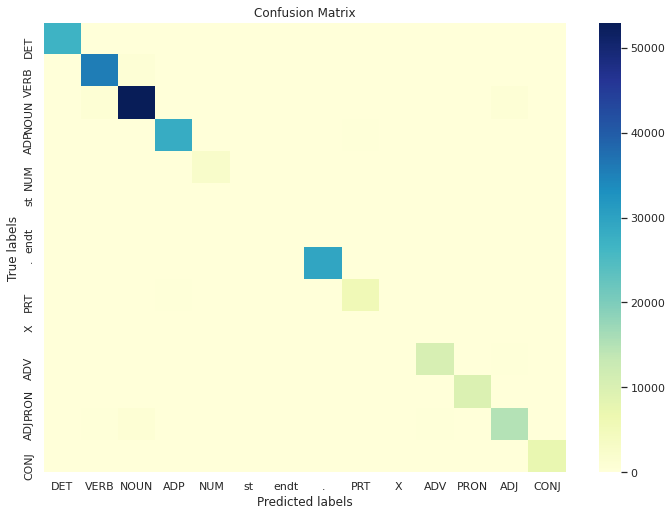

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt  

cm = confusion_matrix(gold_all, pred_all, list(indextags.values()))
print(cm)

sns.set(rc={'figure.figsize':(11.7,8.27)})


ax= plt.subplot()
sns.heatmap(cm, annot=False, ax = ax,cmap="YlGnBu")

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix') 
ax.xaxis.set_ticklabels(list(indextags.keys()))
ax.yaxis.set_ticklabels(list(indextags.keys()));
